In [1]:

from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics
# from EfficientNet import EfficientNet
import torch
import zipfile

In [2]:
!pip install albumentations
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-pjdlv9as
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-pjdlv9as
  Resolved https://github.com/albu/albumentations to commit 7af1951334b856eb2bbb8a5d2094361a790bddad
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# downloading the images

# wget https://challengedata.ens.fr/media/public/train-images.zip
# wget https://challengedata.ens.fr/media/public/test-images.zip
# wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv
# wget.download('https://challengedata.ens.fr/media/public/train-images.zip')
# wget.download('https://challengedata.ens.fr/media/public/test-images.zip')
# wget.download('https://challengedata.ens.fr/media/public/label_Hnl61pT.csv', 'y_train.csv')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# !unzip train-images.zip
# !unzip test-images.zip
# Unzipping the files in folders train-images and test-images

zipfile.ZipFile('drive/MyDrive/Dauphine/College de France/train-images.zip').extractall()
zipfile.ZipFile('drive/MyDrive/Dauphine/College de France/test-images.zip').extractall()


# Handling the data

In [5]:
# Load the train labels
# Note the transpose!
labels_train = pd.read_csv("drive/MyDrive/Dauphine/College de France/y_train.csv", index_col=0).T
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [7]:
# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path
data_dir = Path("./")
data_train = load_dataset(data_dir / "train-images")
data_test = load_dataset(data_dir / "test-images")

In [8]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (2000, 256, 256)
Y_train shape: (2000, 65536)


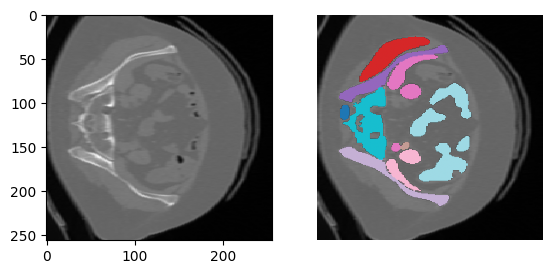

In [9]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256,256)) == 0, (seg.reshape((256,256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

# Let's try it on a slide and ites segmentation mask
# Note: we have to reshape the rows of the dataframe into a 256*256 matrix
plot_slice_seg(data_train[0], labels_train.iloc[0].values.reshape((256,256)))

# Let's compute a baseline

In [10]:
# Let's take a very basic watershed baseline
def compute_baseline_one_sample(data_slice):
    edges = sobel(data_slice)
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

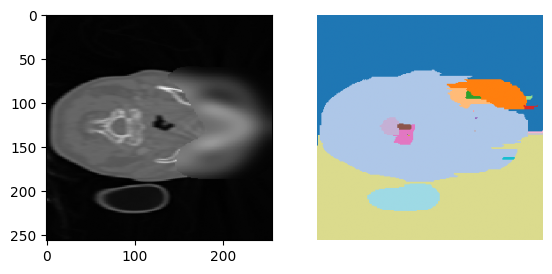

In [11]:
# Let's display the results
# Not too bad!
plot_slice_seg(data_train[2], compute_baseline_one_sample(data_train[2]))

## Let's measure its performances

In [12]:
# Compute the baseline on a whole dataset
def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [13]:
# Let's create a validation set first: the 200 first images of the train set
data_val = data_train[:200]
labels_val = labels_train.iloc[:200]

In [14]:
# Compute baseline on a few train data
labels_val_predicted_baseline = compute_baseline(data_val)

100%|██████████| 200/200 [00:10<00:00, 19.42it/s]


In [15]:
NUM_CLASSES = 54 # 55 classes in total, but the first one is the background


def dice_image(prediction, ground_truth):
    intersection = np.sum(prediction * ground_truth)
    if np.sum(prediction) == 0 and np.sum(ground_truth) == 0:
        return np.nan
    return 2 * intersection / (np.sum(prediction) + np.sum(ground_truth))


def dice_multiclass(prediction, ground_truth):
    dices = []
    for i in range(1, NUM_CLASSES + 1): # skip background
        dices.append(dice_image(prediction == i, ground_truth == i))
    return np.array(dices)

def dice_pandas(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the dice score for each sample in the dataset and then average it"""
    y_pred_df = y_pred_df.T
    y_true_df = y_true_df.T
    individual_dice = []
    for row_index in range(y_true_df.values.shape[0]):
        dices = dice_multiclass(y_true_df.values[row_index].ravel(), y_pred_df.values[row_index].ravel())
        individual_dice.append(dices)

    final = np.stack(individual_dice)
    # First, average over images for each class
    # Then, average over classes
    cls_dices = np.nanmean(final, axis=0)
    return float(np.nanmean(cls_dices))


In [ ]:
# Compute the metric on the validation set
# dice_pandas(labels_val, labels_val_predicted_baseline)
# We get => (0.0011196021617737601); Not so bad, but room for improvements!
# Let's see if you can do better!

In [16]:
# Remove images that contain only label 0
valid_indices = [i for i in range(len(labels_train)) if np.any(labels_train.iloc[i].values > 0)]
filtered_data_train = data_train[valid_indices]

filtered_labels_train = labels_train.iloc[valid_indices]

from sklearn.model_selection import train_test_split

train_size = 0.8
val_size = 0.2

data_train_split, data_val_split = train_test_split(filtered_data_train, train_size=0.8, test_size=0.2, random_state=42)
labels_train_split, labels_val_split = train_test_split(filtered_labels_train, train_size=0.8, test_size=0.2, random_state=42)

print(f"Train labels size:" + str(labels_train_split.shape))
print(f"Validation labels size:" + str(labels_val_split.shape))




Train labels size:(607, 65536)
Validation labels size:(152, 65536)


In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2


transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GaussianBlur(p=0.1),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=2, min_height=8, min_width=8, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

def transform_fn(image, mask):
    augmented = transform(image=image, mask=mask)
    return augmented["image"], augmented["mask"]

<ipython-input-17-29d03528476a>:17: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=2, min_height=8, min_width=8, p=0.5),


In [ ]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
import torch.utils.data

def mask_rcnn_model():
    """Load a pre-trained Mask R-CNN model for instance segmentation."""
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
    model.eval()  # Set to evaluation mode
    return model

def apply_mask_rcnn(model, images):
    """Apply Mask R-CNN to extract object masks from images."""
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    processed_images = []
    with torch.no_grad():
        for image in images:
            img_tensor = torchvision.transforms.functional.to_tensor(image).to(device)
            img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
            outputs = model(img_tensor)[0]

            if len(outputs["masks"]) > 0:
                mask = (outputs["masks"][0, 0] > 0.5).float()  # Use first detected object mask
            else:
                mask = torch.zeros_like(img_tensor[0, 0])

            processed_images.append(mask.cpu().numpy())

    return np.array(processed_images)

def deeplabv3_plus_model(num_class=NUM_CLASSES+1):
    model = torchvision.models.segmentation.deeplabv3_resnet101(weights=torchvision.models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT)
    in_channels = model.classifier[-1].in_channels
    model.classifier[-1] = nn.Conv2d(in_channels, num_class, kernel_size=(1, 1), stride=(1, 1))
    return model

def predict_on_val_set(model, val_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.cuda()
            output = model(x)['out']
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.softmax(preds, dim=1)
        one_hot_targets = torch.nn.functional.one_hot(targets, num_classes=NUM_CLASSES+1).permute(0, 3, 1, 2).float()
        intersection = (preds * one_hot_targets).sum(dim=(2,3))
        dice = (2. * intersection + self.smooth) / (preds.sum(dim=(2,3)) + one_hot_targets.sum(dim=(2,3)) + self.smooth)
        return 1 - dice.mean()

def combined_loss(preds, targets):
    ce_loss = nn.CrossEntropyLoss()(preds, targets)
    dice_loss = DiceLoss()(preds, targets)
    return 0.5 * ce_loss + 0.5 * dice_loss

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)["out"]
            loss = combined_loss(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)["out"]
                loss = combined_loss(output, y)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(torch.load('best_model.pth'))
            break

    return model

# Load Mask R-CNN model
mask_rcnn = mask_rcnn_model()

def format_labels(labels):
    return torch.tensor(labels).long().reshape(256, 256)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]
        y = format_labels(self.Y.iloc[index].values.reshape((256, 256)))

        x = Image.fromarray(x).convert("RGB")  # Convert image to RGB

        # Apply Mask R-CNN on the input image
        mask = apply_mask_rcnn(mask_rcnn, [x])[0]
        x = np.array(x) * np.expand_dims(mask, axis=-1)  # Apply mask to image

        if self.transform:
            x = self.transform(image=x)["image"]

        return x, y

# Create datasets and loaders
train_dataset = Dataset(data_train_split, labels_train_split, transform)
val_dataset = Dataset(data_val_split, labels_val_split, transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

idx = 0
_, true_mask = val_dataset[idx]
print("Unique values in Ground Truth Mask:", torch.unique(true_mask))

# Train the model
model = deeplabv3_plus_model()
trained_model = train_model(model, train_loader, val_loader, num_epochs=200, lr=1e-5, patience=25)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 236MB/s]


Unique values in Ground Truth Mask: tensor([ 0,  3, 11, 36, 37, 54])


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 240MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Training Loss: 2.422095502677717


In [ ]:
# # Dataloaders

# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, X, Y, transform=None):
#         self.X = X
#         self.Y = Y
#         self.transform = transform

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, index):
#         x = self.X[index]
#         y = self.Y[index]
#         if self.transform:
#             x = self.transform(x)
#         return x, y

# train_dataset = Dataset(data_train_split, labels_train_split, transform)
# val_dataset = Dataset(data_val_split, labels_val_split, transform)




In [ ]:
for i in range(5):  # Check first 5 validation samples
    label_sample = labels_val_split.iloc[i].values.reshape((256, 256))  # Ensure correct shape
    print(f"Sample {i} - Unique values in label:", np.unique(label_sample))


Sample 0 - Unique values in label: [ 0  3 11 36 37 54]
Sample 1 - Unique values in label: [ 0  3  4  5 42 50]
Sample 2 - Unique values in label: [ 0 23 27 30 31 47]
Sample 3 - Unique values in label: [ 0  3  5  9 31 32 33 39 47 49]
Sample 4 - Unique values in label: [ 0  3  4 31 32 47 53]


In [ ]:
from tqdm import tqdm
import pandas as pd
import torch.optim.lr_scheduler as lr_scheduler


def deeplabv3_plus_model(num_class=NUM_CLASSES+1):
    model = torchvision.models.segmentation.deeplabv3_resnet101(weights=torchvision.models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT)

    # Change the output layer
    in_channels = model.classifier[-1].in_channels
    model.classifier[-1] = nn.Conv2d(in_channels, num_class, kernel_size=(1, 1), stride=(1, 1))


    return model

def predict_on_val_set(model, val_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.cuda()
            output = model(x)['out']
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.softmax(preds, dim=1)  # Convert logits to probabilities
        one_hot_targets = torch.nn.functional.one_hot(targets, num_classes=NUM_CLASSES+1).permute(0, 3, 1, 2).float()

        intersection = (preds * one_hot_targets).sum(dim=(2,3))
        dice = (2. * intersection + self.smooth) / (preds.sum(dim=(2,3)) + one_hot_targets.sum(dim=(2,3)) + self.smooth)

        return 1 - dice.mean()

def combined_loss(preds, targets):
    ce_loss = nn.CrossEntropyLoss()(preds, targets)
    dice_loss = DiceLoss()(preds, targets)
    loss = 0.5 * ce_loss + 0.5 * dice_loss
    return loss

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    # Learning rate scheduler (Cosine Annealing)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)["out"]
            loss = combined_loss(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}")

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)["out"]
                loss = combined_loss(output, y)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss}")

        # Step the ReduceLROnPlateau scheduler (pass validation loss)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(torch.load('best_model.pth'))
            break

    return model


In [ ]:
from PIL import Image

model = deeplabv3_plus_model()

# Ensure labels are in the correct format
def format_labels(labels):
	return torch.tensor(labels).long().reshape(256, 256)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]
        y = format_labels(self.Y.iloc[index].values.reshape((256, 256)))  # Ensure correct shape

        x = Image.fromarray(x).convert("RGB")  # Convert image to RGB
        if self.transform:
            x = self.transform(image=np.array(x))["image"]  # Apply transforms correctly

        return x, y


train_dataset = Dataset(data_train_split, labels_train_split, transform)
val_dataset = Dataset(data_val_split, labels_val_split, transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)


idx = 0

_, true_mask = val_dataset[idx]

# Check unique values in the ground truth mask
print("Unique values in Ground Truth Mask:", torch.unique(true_mask))


trained_model = train_model(model, train_loader, val_loader, num_epochs=200, lr=1e-5, patience=25)



Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:00<00:00, 279MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Unique values in Ground Truth Mask: tensor([ 0,  3, 11, 36, 37, 54])


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Save the trained model
torch.save(trained_model.state_dict(), 'trained_model.pth')


In [ ]:
# import torch
# import numpy as np

# def to_one_hot(tensor, num_classes):
#     """Convert class indices to one-hot encoding"""
#     one_hot = torch.nn.functional.one_hot(tensor, num_classes=num_classes).permute(0, 3, 1, 2)
#     return one_hot

# def dice_multiclass(prediction, ground_truth, num_classes=55):
#     """Compute Dice for each class, excluding background"""
#     dices = []
#     for i in range(1, num_classes):  # Exclude background class (0)
#         pred_class = (prediction == i).float()
#         gt_class = (ground_truth == i).float()

#         intersection = torch.sum(pred_class * gt_class)
#         union = torch.sum(pred_class) + torch.sum(gt_class)

#         dice_score = (2. * intersection + 1e-6) / (union + 1e-6)  # Avoid division by zero
#         dices.append(dice_score.item())

#     return np.nanmean(dices)  # Mean across classes


In [ ]:
# model.eval()
# val_loss = 0.0
# dice_scores = []
# criterion = nn.CrossEntropyLoss()

# with torch.no_grad():
#     for x, y in val_loader:
#         x, y =  x.cuda(), y.cuda()
#         output = model(x)["out"]  # Model output

#         # Convert to class indices
#         predicted = torch.argmax(output, dim=1)

#         # Compute loss
#         loss = criterion(output, y)
#         val_loss += loss.item()

#         # Convert both prediction and ground truth to one-hot encoding
#         predicted_one_hot = to_one_hot(predicted, num_classes=55)
#         y_one_hot = to_one_hot(y, num_classes=55)

#         # Compute Dice score
#         dice_scores.append(dice_multiclass(predicted_one_hot, y_one_hot, num_classes=55))

# val_loss /= len(val_loader)
# dice_score_mean = np.mean(dice_scores)

# print(f"Validation Loss: {val_loss:.4f}, Dice Score: {dice_score_mean:.4f}")


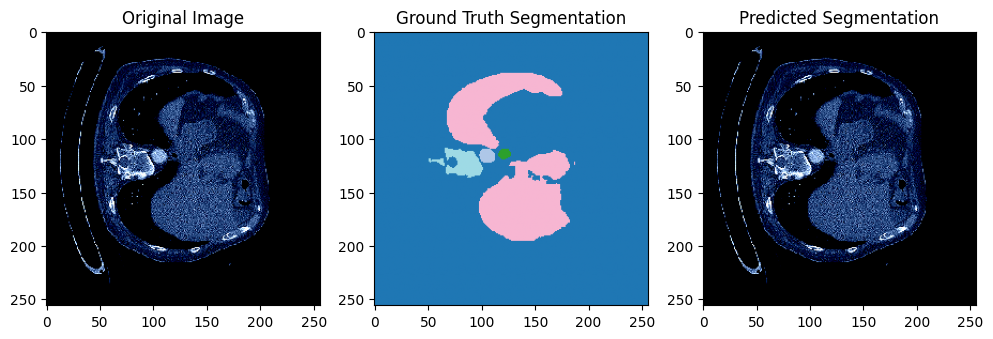

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_predicted_segmentation(model, dataset, idx, device="cuda"):
    """
    Plots the original image and the predicted segmentation.

    Args:
        model: Trained segmentation model.
        dataset: Dataset containing images and labels.
        idx: Index of the image to visualize.
        device: "cuda" or "cpu".
    """
    model.eval()
    image, true_mask = dataset[idx]  # Load image and ground truth mask
    image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

    with torch.no_grad():
        output = model(image_tensor)["out"]  # Get model output
        predicted_mask = torch.argmax(output, dim=1).cpu().numpy()[0]  # Convert to class indices

    # Plot original image and segmentation
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].imshow(image.permute(1, 2, 0).cpu().numpy())  # Convert tensor to NumPy image
    axes[0].set_title("Original Image")

    axes[1].imshow(true_mask.cpu().numpy(), cmap="tab20")  # Ground truth
    axes[1].set_title("Ground Truth Segmentation")

    axes[2].imshow(image.permute(1, 2, 0).cpu().numpy())  # Overlay on image
    predicted_mask_overlay = np.ma.masked_where(predicted_mask == 0, predicted_mask)
    axes[2].imshow(predicted_mask_overlay, cmap="tab20", alpha=0.6)
    axes[2].set_title("Predicted Segmentation")

    plt.show()

# Example usage
plot_predicted_segmentation(trained_model, val_dataset, idx=0)


In [ ]:
def predict_on_val_set(model, val_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.cuda()
            output = model(x)['out']
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

predictions = predict_on_val_set(trained_model, val_loader)

# Reshape predictions and convert to DataFrame
reshaped_predictions = [pred.reshape(-1) for pred in predictions]
labels_val_predicted_model = pd.DataFrame(reshaped_predictions)

dice_score = dice_pandas(labels_val_split, labels_val_predicted_model)
print(f"Dice score on validation set: {dice_score}")


Dice score on validation set: 0.0


<ipython-input-14-026daa8c8e93>:29: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


In [ ]:
def predict_on_test_set(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for x in tqdm(test_loader):  # No labels in test loader
            x = x.cuda()
            output = model(x)['out']
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions



# Assuming 'data_test' is your test data
class TestDataset(torch.utils.data.Dataset):
  def __init__(self, X, transform=None):
    self.X = X
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    x = self.X[index]
    x = Image.fromarray(x).convert("RGB")  # Convert image to RGB
    if self.transform:
      x = self.transform(image=np.array(x))["image"]  # Apply transforms correctly
    return x

test_dataset = TestDataset(data_test, transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


# Make predictions on the test set
predictions = predict_on_test_set(trained_model, test_loader)

# Reshape predictions and convert to DataFrame
reshaped_predictions = [pred.reshape(-1) for pred in predictions]
y_pred_df = pd.DataFrame(reshaped_predictions)

# Save predictions to Y_test.csv
# y_pred_df.to_csv("Y_test.csv", index=False)


100%|██████████| 16/16 [00:03<00:00,  5.09it/s]


In [ ]:
for i in range(min(len(predictions), 5)): # Display the first 5 images and their segmentations
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(data_test[i], cmap='gray')  # Original Image
    plt.title(f'Test Image {i+1}')

    plt.subplot(1, 2, 2)
    plt.imshow(predictions[i], cmap='jet')  # Segmentation mask with a colormap
    plt.title(f'Predicted Segmentation {i+1}')

    plt.show()
